In [13]:
import pandas as pd
import numpy as np
import tensorflow as tf
import numpy as np
import pandas as pd
import os
from matplotlib import  pyplot as plt
from sklearn.metrics import auc, confusion_matrix

In [47]:
class Data:
    def __init__(self,crypto_name):
        self.X_tr = None
        self.X_te = None
        self.X_va = None

        self.y_tr = None
        self.y_te = None
        self.y_va = None
        self.df = None
        self.crypto_name = crypto_name

    def load_data(self):
        try:
            self.df = pd.read_csv(f'./data/processed/{self.crypto_name}_finaldb_fct.csv').dropna()
        except FileNotFoundError:
            self.df = pd.read_csv(f'../data/processed/{self.crypto_name}_finaldb_fct.csv').dropna()
        self.df = self.df.iloc[:,1:]
        self.df['Close_std'] = (self.df['Close']-self.df['Close'].mean())/self.df['Close'].std()
        self.df['Close_ret'] = np.log(self.df[['Close']].shift(-1).values/self.df[['Close']].values)
    
    def create_RNN_data(self,LAG=10,reg="Price"):
        
        if reg == "Price":
            y=self.df[['Close_std']].values
        else:
            y= self.df[['Close_ret']].iloc[1:,:].values
        
        #print(y)
        X = []
        xx = self.df[["Volume","MA_100","coinmarketcap","justinsuntron"]]
        for i in range(LAG+1,0-1,-1):
            if i > 0:
                X.append(xx[LAG+1 - i:-i])
            else:
                X.append(xx[LAG+1 - i:])



        X = np.concatenate(X, 1)
        y = y[-X.shape[0]:,:]
        # X = X[:,:]
        #print(X.shape)
        #print(y.shape)
        X = X.reshape((X.shape[0], X.shape[1], 1)) # add the input dimension !
        #print(X.shape)
        #print(X)
        y = y[:-1,:]
        #print(y)
        X = X[:-1,:]
        ind = np.arange(0, y.shape[0], 1)
        tr = int(np.ceil(len(ind) * 0.8))
        te = int(np.ceil(len(ind) * 0.9))
        
        self.X_tr = X[np.where(ind[:tr])[0], :]
        self.X_te = X[np.where(ind[tr:te])[0], :]
        self.X_va = X[np.where(ind[te:])[0], :]

        self.y_tr = y[np.where(ind[:tr])[0], :]
        self.y_te = y[np.where(ind[tr:te])[0], :]
        self.y_va = y[np.where(ind[te:])[0], :]

## Debug ##

data = Data("ETH")
data.load_data()
#choose for our estimation
data.create_RNN_data(reg='return',LAG=10)

In [48]:
class DNN:
    def __init__(self):
        self.model = None
        self.hist_training = None

    def create_model(
            self,
            data,
            learning_rate=0.005,
            opti='adam',  # you can put 'adam', 'sgd', or 'rms_prop'
            batch_normalization=False,
            activation='relu',  # 'sigmoid', or 'relu' are the main two, but others are coded in keras (see documentation)
            architecture=[64, 32, 16],  # each number correspond to a number of neurons in a layer
            drop_out=0.0,
            verbose=0):

        # check that the input are correct
        assert type(architecture) == list, 'architecture must be a list of integers (e.g. [64,32,16], each representing a number of neurones in a layer'
        assert opti in ['adam', 'sigmoid', 'rms_prop'], "invalid optimizer, please chose among ['adam','sigmoid','rms_prop']"
        assert type(data) == Data, 'the data object must come from the "Data" class'

        # extract the input shape and output shape from the data

        # select the optimizer
        if opti == 'sgd':
            optimizer = tf.keras.optimizers.SGD(learning_rate)
        if opti == 'rms_prop':
            optimizer = tf.keras.optimizers.RMSprop(learning_rate)
        if opti == 'adam':
            optimizer = tf.keras.optimizers.Adam(learning_rate)

        output_dim = data.y_te.shape[1]
        model = self._create_network(data, architecture, batch_normalization, activation, drop_out)

        ##################
        # define an additional metrics
        ##################
        if output_dim == 1:
            # here we do a regression---that, is we predict one continous thing, hence we can add the R squared as a metric
            def r_square(y_true, y_pred):
                SS_res = tf.reduce_sum(tf.square(y_true - y_pred))
                SS_tot = tf.reduce_sum(tf.square(y_true - tf.reduce_mean(y_true)))
                return (1 - SS_res / (SS_tot + tf.keras.backend.epsilon()))

            # we have three metrics:
            # mean absolute error -> mae
            # mean square error -> mse
            # and our custom r-square.
            model.compile(loss='mae', optimizer=optimizer, metrics=['mae', 'mse', r_square])
        if output_dim > 1:
            # here we do a classifier ---that, is we predict a percentage of being in one dimension instead of another
            # we have two  metrics:
            # mean absolute error -> mae
            # accracy
            model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=False), optimizer=optimizer, metrics=['accuracy', 'mae'])
        if verbose:
            # if specified, print the network architecture
            print(model.summary())
        self.model = model

    def _create_network(self, data, architecture, batch_normalization, activation, drop_out):
        input_dim = data.X_te.shape[1]
        output_dim = data.y_te.shape[1]
        # build the network
        L = []
        for i, l in enumerate(architecture):
            if i == 0:
                L.append(tf.keras.layers.Dense(l, activation=activation, input_shape=[input_dim]))  # add the first layer
            else:
                L.append(tf.keras.layers.Dense(l, activation=activation))  # add a layer
            if drop_out > 0.0:
                L.append(tf.keras.layers.Dropout(rate=drop_out, seed=12345))

            if batch_normalization:
                # add batch normalization if specified
                L.append(tf.keras.layers.BatchNormalization())

        # add the final layer
        if output_dim == 1:
            L.append(tf.keras.layers.Dense(output_dim))
        else:
            # if we are doing classification, we wish to normalize the ouput between 0 and 1, hence the softmax
            L.append(tf.keras.layers.Dense(output_dim, activation='softmax'))

        # keras command to build a simple feed forward network with the parameters defined above
        model = tf.keras.Sequential(L)
        return model

    def show_performance(self, label_, data):

        assert type(data) == Data, 'the data object must come from the "Data" class'

        # check the output_dim to calibrate the plot
        output_dim = data.y_te.shape[1]

        # use the pandas function to start the plot (history training is a PD data frame).
        self.hist_training[['loss', 'val_loss']].plot()
        plt.grid(True)  # add a grid for visibiliy
        plt.xlabel('epochs')
        if output_dim == 1:
            plt.ylabel('mean absolute error')  # if its a regression, we plot the mae
        else:
            plt.ylabel('cross entropy loss')  # if its a classification, we plot the cross entropy loss
        plt.title(label_)
        plt.savefig(label_ + '.png')
        plt.show()

        if output_dim == 1:
            # if regression, compute the out of sample performance measure
            print('=' * 50)
            print('Out of sample performance:')
            self.model.evaluate(data.X_te, data.y_te, verbose=2)
            print('=' * 50)

        else:
            # if classification  print the  confusion matrix
            pred = self.model.predict(data.X_te)
            cf = confusion_matrix(y_true=np.argmax(data.y_te, 1), y_pred=np.argmax(pred, 1))
            cf = pd.DataFrame(cf)
            index = ['True ' + str(x) for x in cf.index]
            col = ['Predicted ' + str(x) for x in cf.columns]
            cf.index = index
            cf.columns = col
            print(cf)

    def train_model(self, data, epoch=10, bs=256, verbose=0, tensor_board_name=None):
        assert type(data) == Data, 'the data object must come from the "Data" class'
        tf.random.set_seed(1234)
        np.random.seed(1234)
        print('### start training for', epoch, 'epochs')
        # Prepare the validation dataset
        val_dataset = tf.data.Dataset.from_tensor_slices((data.X_va, data.y_va))
        val_dataset = val_dataset.batch(256)

        if tensor_board_name is not None:
            # set_up the tensorboard name

            log_dir = "logs/" + tensor_board_name  # +"/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
            tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
            history_training = self.model.fit(x=data.X_tr, y=data.y_tr, batch_size=bs, epochs=epoch, validation_data=val_dataset, verbose=verbose, callbacks=tensorboard_callback)

        else:
            # the keras command to launch the training routine
            history_training = self.model.fit(x=data.X_tr, y=data.y_tr, batch_size=bs, epochs=epoch, validation_data=val_dataset, verbose=verbose)
        print('### training finish \n')

        # return the history of training process
        self.hist_training = pd.DataFrame(history_training.history)



class RNN(DNN):
    def __init__(self):
        super().__init__()
        self.model = None
        self.hist_training = None

    def _create_network(self, data, architecture, batch_normalization,activation, drop_out):

        output_dim = data.y_te.shape[1]
        # build the network
        #print(data.X_te.shape)
        L = [tf.keras.layers.Input(shape=(data.X_te.shape[1],data.X_te.shape[2]))] # very important input layer

        for i, l in enumerate(architecture):
            if i == 0:
                L.append(tf.keras.layers.LSTM(l)) # first layer is now an SLTM
            else:
                L.append(tf.keras.layers.Dense(l, activation=activation))  # add a layer
            if drop_out > 0.0:
                L.append(tf.keras.layers.Dropout(rate=drop_out, seed=12345))

            if batch_normalization:
                # add batch normalization if specified
                L.append(tf.keras.layers.BatchNormalization())


        # add the final layer
        if output_dim == 1:
            L.append(tf.keras.layers.Dense(output_dim, activation='tanh'))
        else:
            # if we are doing classification, we wish to normalize the ouput between 0 and 1, hence the softmax
            L.append(tf.keras.layers.Dense(output_dim, activation='softmax'))

        # keras command to build a simple feed forward network with the parameters defined above
        model = tf.keras.Sequential(L)
        return model

## Debug ##

model=RNN()

model.create_model(data,architecture=[10],batch_normalization=False,activation="swish")
model.train_model(data,verbose=1,epoch=100)
model.show_performance(label_='Error graph',data=data)
pred=model.model(data.X_te)

plt.plot(pred.numpy().flatten(),color='k',label='Pred')
plt.plot(data.y_te.flatten(),color='blue',linestyle='--',label='True')
plt.legend()
plt.show()

(98, 48, 1)
### start training for 100 epochs


KeyboardInterrupt: 

In [6]:
data.X_tr[-1]

array([[-0.13975805],
       [ 0.05174094],
       [ 0.00223673],
       [-0.04689852],
       [ 0.03911925],
       [ 0.04753392],
       [ 0.0153733 ],
       [-0.01948579],
       [ 0.02878322],
       [-0.03524475],
       [ 0.00287999]])

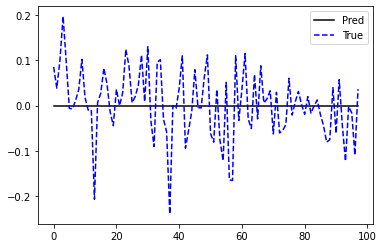

In [36]:
# model=RNN()

# model.create_model(data,architecture=[10],batch_normalization=False,activation="swish")
# model.train_model(data,verbose=1,epoch=100)
# model.show_performance(label_='Error graph',data=data)
# pred=model.model(data.X_te)


plt.plot(pred.numpy().flatten(),color='k',label='Pred')
plt.plot(data.y_te.flatten(),color='blue',linestyle='--',label='True')
plt.legend()
plt.show()